# Notebook for exploring Protein-Protein interactions and unbinding pathways using pre-computed Protein-Protein Interaction dataframes


**Aim**: Detect unbinding pathways from dissociation trajectories generated by the RAMD method (Random Acceleration Molecular Dynamics) usigng PP-REs (Protein-Protein REsidue pairs)

**Version**: 1.0 (10.01.2021), 1.1 (07.02.2024), Copyright (c) 2024, Released under the EUPL Licence, v1.2 or any higher version

**Authors/Contributions**: 1.0: Daria Kokh, Rebecca Wade (HITS, Heidelberg, Germany), 1.1 Update: Giulia D'Arrigo, Rebecca Wade (HITS, Heidelberg, Germany)

**Contact**: mcmsoft@h-its.org

The notebook includes:
1. Clustering of all frames in dissociation trajectories based on PP-RE contacts (k-means clustering)
2. Detection of unbinding pathways and IFP
3. Clustering of the pre-dissociation frames (hierarchical clustering)
4. Supplementary plots

   4.1 RMSD of equilibration trajectories
   
   4.2 Interfacial and buried water counting during equilibration trajectories

**Input data required**:
Dataframes (.pkl) generated by the scripts IFP_PP.py, IFP_PP-EQ.py and combine_all_data-PP.py

**Packages required**:
numpy
matplotlib
pandas
seaborn
code is written on Python 3.x and tested on the version 3.7
PP_analysis.py (containes the main functions used in this notebook)


In [22]:
##import packages needed for the notebook 

import glob, os
import sys
import subprocess
import numpy as np

import pandas as pd
from pandas import ExcelFile 

from matplotlib import *
import matplotlib as mpl
from matplotlib import cm
from matplotlib.patches import Arrow, Circle
import matplotlib.gridspec as GS
import matplotlib.ticker
import  pylab as plt
import seaborn
import seaborn as sns
import more_itertools as mit
from itertools import groupby


#import ipywidgets as widgets
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.cluster import KMeans
from matplotlib import gridspec

from scipy import stats
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import pairwise_distances

from scipy.optimize import curve_fit
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

In [24]:
## import all the functions needed for the notebook

from Scripts.JN_scripts import *

### Define working directory and mutants to be analysed

- Choose the system of interest

- If **EQ_WATER** and **RAMD_WATER** are set to **True**, the notebook will read also the dataframes containing water counting for analysis.

In [25]:
dir_all="/hits/basement/mcm/darrigo/ZENODO/"

system="BN_BS" #change name system accordingly

if system == "BN_BS":
    dirr_mu = "/hits/basement/mcm/darrigo/ZENODO/BN-BS/pkl_files/19kcalmol/"
    name_mu=["WT1", "D35A1", "D39A1", "H102A1", "K27A1", "D54A1","R59A1","Y29A2","E60A1","E73A1","E76A1","E80A1","N58A1","R87A1","T42A1","H102D39A1","K27D39A1","K27D35A1","K27Y29A1","H102Y29A1","K27E76A1","H102E76A1","R87Y29A1"]

elif system == "BT_BPTI":
    dirr_mu = "/hits/basement/mcm/darrigo/ZENODO/BT_BCT-BPTI/pkl_files/17kcalmol/"
    name_mu = ["BT-BPTI_WT","BT-BPTI_G36A","BT-BPTI_K15A","BT-BPTI_G12A","BT-BPTI_IL18A","BT-BPTI_R17A","BT-BPTI_R20A"]

else:
    dirr_mu = "/hits/basement/mcm/darrigo/ZENODO/BT_BCT-BPTI/pkl_files/17kcalmol/"
    name_mu = ["CBT-BPTI_WT", "CBT-BPTI_G36A","CBT-BPTI_IL18A","CBT-BPTI_K15A","CBT-BPTI_G12A","CBT-BPTI_R17A","CBT-BPTI_R20A"]


RAMD_WATER = False
EQ_WATER = False

# considered to be bonding contact (Angstrom)
threshold = 5.5

### Reading the PP-IFP files (.pkl)

In [4]:
df_E_mu = []
dfW_E_mu = []
df_D_mu = []
dfW_D_mu = []

cols_mu = []  #-------- array that contains a set of resi-resi contacts for each mutant
cols_mu_tot = []   #-------- a set of resi-resi contacts for all mutants togeather
for n in name_mu:
    df_E_mu.append(pd.read_pickle(dirr_mu+n+"-EQ.pkl"))
    if EQ_WATER:
        dfW_E_mu.append(pd.read_pickle(dirr_mu+n+"-EQ_water.pkl"))
    df = pd.read_pickle(dirr_mu+n+"-RAMD.pkl")
    df_D_mu.append(df)
    if RAMD_WATER:
        dfW_D_mu.append(pd.read_pickle(dirr_mu+n+"-RAMD_water.pkl"))
    else: dfW_D_mu.append([])
    cols = []
    [cols.append(c) for c in df.columns.values if str(c[0]).isdigit()] 
    cols_mu.append(cols)
    [cols_mu_tot.append((c1,c2)) for c1,c2 in zip(np.array(cols).T[0],np.array(cols).T[1]) \
         if (not (c1,c2) in cols_mu_tot) and (df[(c1,c2)].min(0)<= threshold*10)]
    
df_E_wt =  df_E_mu[0]  
if EQ_WATER: dfW_E_wt = dfW_E_mu[0]
if RAMD_WATER:  dfW_D_wt = dfW_D_mu[0]
df_D_wt = df_D_mu[0]
cols_wt = []
[cols_wt.append(c) for c in df_D_wt.columns.values if str(c[0]).isdigit()]
shape1 = cols_wt[-1][0]-cols_wt[0][0]+1
shape2 = cols_wt[-1][1]-cols_wt[0][1]+1
print("Columns in WT:",len(cols_wt))
print("Total different columns (with at least one contact below the threshold) in all mutants:",len(cols_mu_tot))

Columns in WT: 1916
Total different columns (with at least one contact below the threshold) in all mutants: 435


### Analysis of the equilibration trajectories and definition of the BS-REs (Binding Site REsidues)

**(1) BS-REs in WT complex**
   - The PP-REs below the treshold distance (5.5 Angstrom) in at least one snapshot of the equilibration trajecotry of the WT complex are extracted from the whole dataframe (df_E_wt)
   - If these PP-REs are present for more than half of the equilibration trajectory are defined as BS-REs

**(2) BS-REs in mutant complexes**
   - The PP-REs below the treshold distance (5.5 Angstrom) in at least one snapshot of the equilibration trajecotry of the WT complex are extracted from the whole dataframe (df_E_mu)
   - If these PP-REs are present for more than half of the equilibration trajectory are defined as BS-REs

**(3) show BS-REs as heatmap for all mutants and WT**

In [5]:
print("The total PP-REs of contacts is " + str(len(cols_wt)))
bond_contacts_prelim = df_E_wt[cols_wt].columns[(df_E_wt[cols_wt].min(axis=0)/10. < threshold).values]
print("\n"+ "The number of PP-REs whose distance is below the threshold in at least one snapshot is "+str(len(bond_contacts_prelim))+"\n"+ str(bond_contacts_prelim.values))
df_sele =df_E_wt[bond_contacts_prelim]
sele = df_sele[df_sele > threshold*10].isna().sum() > (df_sele.shape[0])*0.5 
bond_contacts = bond_contacts_prelim[sele.values].values
print("\n"+"The final number of binding site (BS-REs) contacts in WT is " + str(bond_contacts.shape[0]) + '\n' + str(bond_contacts))  #binding site residues  for WT

The total PP-REs of contacts is 1916

The number of PP-REs whose distance is below the threshold in at least one snapshot is 69
[(27, 38) (27, 39) (27, 42) (27, 43) (27, 80) (28, 79) (28, 80) (28, 81)
 (31, 42) (31, 43) (31, 47) (31, 80) (31, 81) (31, 82) (31, 83) (36, 46)
 (37, 43) (37, 44) (38, 43) (38, 44) (38, 45) (38, 46) (39, 46) (56, 35)
 (57, 34) (57, 35) (57, 38) (57, 76) (58, 35) (59, 34) (59, 35) (59, 38)
 (59, 69) (59, 72) (59, 73) (59, 76) (60, 33) (60, 34) (60, 35) (61, 35)
 (62, 31) (62, 35) (73, 39) (82, 29) (82, 44) (83, 29) (83, 39) (83, 42)
 (83, 43) (84, 29) (85, 29) (87, 39) (101, 31) (101, 33) (102, 29)
 (102, 31) (102, 33) (102, 36) (102, 39) (103, 31) (103, 33) (103, 35)
 (103, 36) (103, 39) (104, 29) (104, 30) (104, 31) (104, 32) (104, 33)]

The final number of binding site (BS-REs) contacts in WT is 38
[(27, 38) (27, 39) (27, 42) (38, 44) (38, 45) (38, 46) (56, 35) (57, 34)
 (57, 35) (57, 38) (58, 35) (59, 34) (59, 35) (59, 72) (59, 73) (59, 76)
 (60, 33) (60,

In [6]:
all_sele = bond_contacts
bond_contacts_mu = []
for df,name,cols in zip(df_E_mu,name_mu,cols_mu):
    bond_contacts_prelim = df[cols].columns[(df[cols].min(axis=0)/10. < threshold).values]
    df_sele =df_E_wt[bond_contacts_prelim]
    sele = df_sele[df_sele > threshold*10].isna().sum() > (df_sele.shape[0])*0.5
    bond_contacts_Mu = bond_contacts_prelim[sele.values]
    all_sele=np.append(all_sele,bond_contacts_Mu.values)
    bond_contacts_mu.append(bond_contacts_Mu.values)
    print(str(name)+ ": The number of PP-REs whose distance is below the threshold in at least one snapshot is "+str(len(bond_contacts_prelim))+"\n"+ str(bond_contacts_prelim.values)+"\n")
    print(str(name)+ ": The final number of BS-REs contacts is "+str(len(bond_contacts_Mu))+"\n"+str(bond_contacts_Mu) +"\n")

bond_contacts=np.unique(all_sele)
print("The overall final number of BS-REs contacts is: " + str(bond_contacts.shape[0]) +"\n"+ str(bond_contacts))   # a set of residues that belong to the binding site to at least one mutant

WT1: The number of PP-REs whose distance is below the threshold in at least one snapshot is 69
[(27, 38) (27, 39) (27, 42) (27, 43) (27, 80) (28, 79) (28, 80) (28, 81)
 (31, 42) (31, 43) (31, 47) (31, 80) (31, 81) (31, 82) (31, 83) (36, 46)
 (37, 43) (37, 44) (38, 43) (38, 44) (38, 45) (38, 46) (39, 46) (56, 35)
 (57, 34) (57, 35) (57, 38) (57, 76) (58, 35) (59, 34) (59, 35) (59, 38)
 (59, 69) (59, 72) (59, 73) (59, 76) (60, 33) (60, 34) (60, 35) (61, 35)
 (62, 31) (62, 35) (73, 39) (82, 29) (82, 44) (83, 29) (83, 39) (83, 42)
 (83, 43) (84, 29) (85, 29) (87, 39) (101, 31) (101, 33) (102, 29)
 (102, 31) (102, 33) (102, 36) (102, 39) (103, 31) (103, 33) (103, 35)
 (103, 36) (103, 39) (104, 29) (104, 30) (104, 31) (104, 32) (104, 33)]

WT1: The final number of BS-REs contacts is 38
Index([ (27, 38),  (27, 39),  (27, 42),  (38, 44),  (38, 45),  (38, 46),
        (56, 35),  (57, 34),  (57, 35),  (57, 38),  (58, 35),  (59, 34),
        (59, 35),  (59, 72),  (59, 73),  (59, 76),  (60, 33),  

E80A1: The number of PP-REs whose distance is below the threshold in at least one snapshot is 67
[(27, 38) (27, 39) (27, 42) (27, 43) (28, 80) (31, 42) (31, 43) (31, 47)
 (31, 80) (31, 81) (31, 82) (36, 46) (37, 43) (37, 44) (38, 44) (38, 45)
 (38, 46) (38, 47) (39, 46) (39, 47) (56, 35) (57, 34) (57, 35) (57, 38)
 (57, 76) (58, 35) (59, 34) (59, 35) (59, 38) (59, 69) (59, 72) (59, 73)
 (59, 76) (60, 33) (60, 34) (60, 35) (61, 35) (62, 31) (62, 32) (73, 39)
 (73, 42) (82, 29) (82, 44) (83, 29) (83, 39) (83, 42) (83, 43) (83, 44)
 (84, 29) (85, 29) (87, 39) (101, 33) (102, 29) (102, 31) (102, 33)
 (102, 36) (102, 39) (103, 31) (103, 33) (103, 35) (103, 36) (103, 39)
 (104, 29) (104, 30) (104, 31) (104, 32) (104, 33)]

E80A1: The final number of BS-REs contacts is 38
Index([ (27, 38),  (27, 39),  (27, 42),  (38, 44),  (38, 45),  (38, 46),
        (56, 35),  (57, 34),  (57, 35),  (57, 38),  (58, 35),  (59, 34),
        (59, 35),  (59, 72),  (59, 73),  (59, 76),  (60, 33),  (60, 34),
     

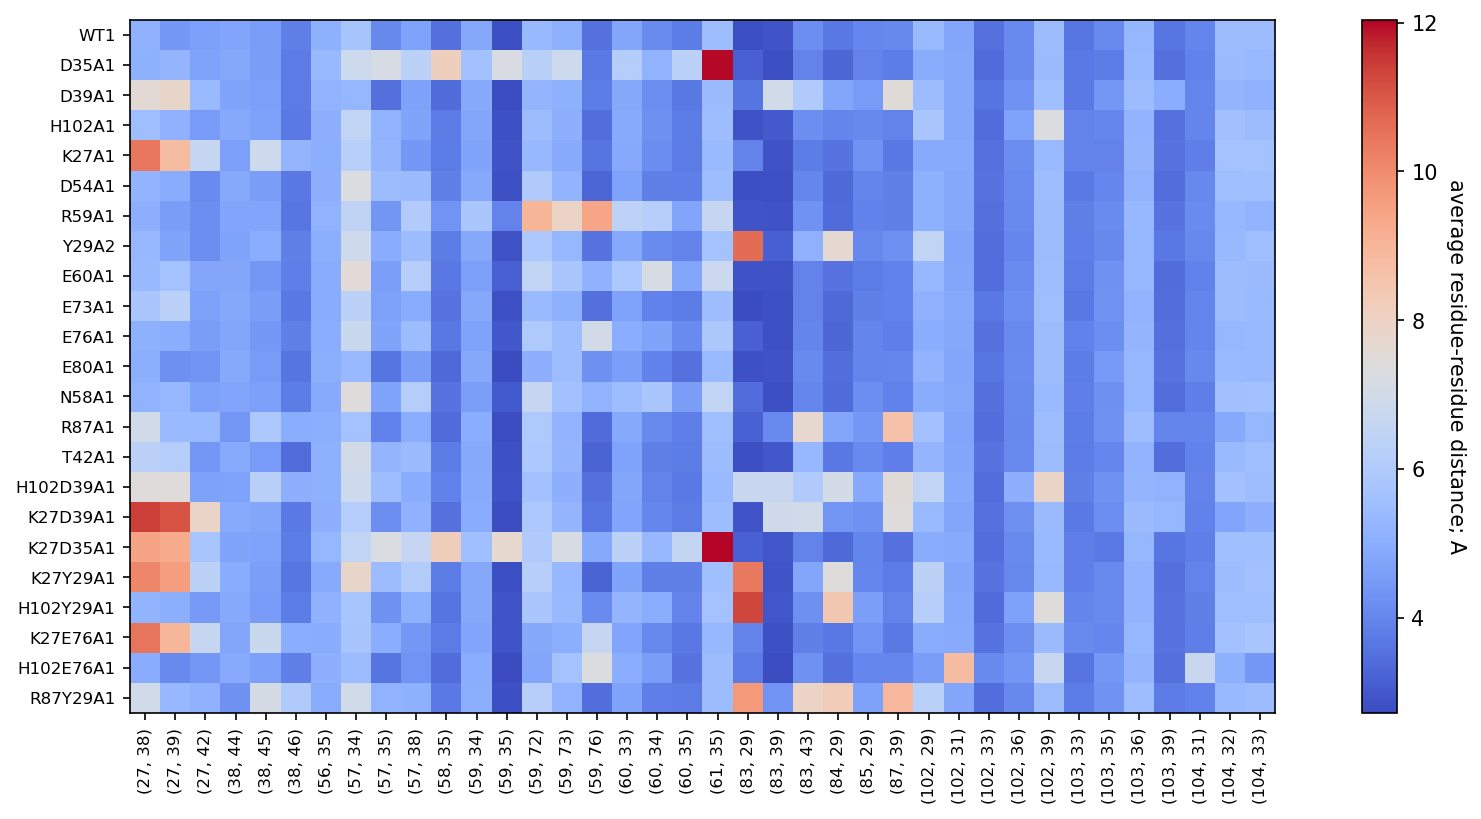

In [7]:
contact_diagram = []
for df,name,cols in zip(df_E_mu,name_mu,cols_mu):
     contact_diagram.append(0.1*np.mean(df[bond_contacts].values, axis = 0))           
fig, ax =  plt.subplots(figsize = (15, 6),dpi=150)
im =  ax.imshow(contact_diagram,cmap="coolwarm")
cbar = ax.figure.colorbar(im, ax=ax)
plt.xticks(np.arange(len(bond_contacts)),bond_contacts,fontsize=8,rotation=90)  #ho tolto +1 altrimenti non plottava bene
plt.yticks(np.arange(len(name_mu)),name_mu,fontsize=8)
cbar.ax.set_ylabel("average residue-residue distance; A", rotation=-90, va="bottom")
plt.show()

## 1. Clustering of dissociation trajectories frames baseed on PP-REs

--- To be executed for every mutant ---

### 1.1 Extract the part of RAMD trajectories to be analysed by clustering


With the cell below the PP-REs dataframe is shrinked to the part of the RAMD trajectories of interest. This corresponds to the frames satisying the "by residue first" method plus the preceding 200 frames.


In [9]:
df_mu = df_D_mu[15]  #index number of the corresponding analysed system: e.g., in this notebook 0 for WT, 1 for D35A
tau_list_r1 = np.zeros(0)                     

clust_cols = cols_mu_tot    #list of all contacts <= threshold 5.5 A

for p in ["COM","RMSD12","Repl","Traj","time","Pr"]:  
    if not p in clust_cols:
        clust_cols.append(p)
        
for c in clust_cols:
    if  c in df_mu.columns: continue
    else:  df_mu.insert(0,c,150)
for r in np.unique(df_mu.Repl):
    df_r = df_mu[df_mu.Repl == r]
    for ti, tr in enumerate(np.unique(df_r.Traj)):
        k = df_r[df_r.Traj == tr]
        if k.time.values.shape[0] < 2: continue

        if len(bond_contacts_mu[15]) > 0:   #index number of the corresponding analysed system
            k1 = k[bond_contacts_mu[15]]    #index number of the corresponding analysed system
            k2 = k.time.values[k1.values.mean(axis=1) > threshold*10]
            if len(k2)>1:
                time=k2[1]
                time2=time-200
                k3=k[k.time.values> time2]
                time_matrix_2 = k3[clust_cols].values
                if time2 <200:
                    k3=k
            if tau_list_r1.shape[0] == 0 :   
                tau_list_r1 = time_matrix_2
            else:
                tau_list_r1 = np.append(tau_list_r1,time_matrix_2, axis = 0)

df_tot = pd.DataFrame(np.array(tau_list_r1),columns = clust_cols)
df_tot=df_tot.drop_duplicates() 
cols = clust_cols[:-6]
df_tot 

,"(27, 35)","(27, 36)","(27, 38)","(27, 39)","(27, 41)","(27, 42)","(27, 43)","(27, 80)","(28, 42)","(28, 80)",...,"(107, 82)","(108, 76)","(108, 80)","(110, 80)",COM,RMSD12,Repl,Traj,time,Pr
0,99,107,72,66,89,48,70,116,98,109,...,150,150,150,150,24.4,2.4,1,101,0,H102D39A1
1,89,100,67,63,88,53,78,107,93,96,...,150,150,150,150,24.1,1.9,1,101,1,H102D39A1
2,98,114,71,74,92,55,92,91,103,94,...,150,150,150,150,24.2,2.6,1,101,2,H102D39A1
3,102,116,74,83,93,55,94,76,104,76,...,150,150,150,150,24.1,2.4,1,101,3,H102D39A1
4,106,113,73,69,86,43,74,95,94,107,...,150,150,150,150,24.5,2.5,1,101,4,H102D39A1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6303,150,150,150,150,150,150,150,150,150,150,...,150,150,150,150,34.4,20.1,6,615,48,H102D39A1
6304,150,150,150,150,150,150,150,150,150,150,...,150,150,150,150,37.6,26.4,6,615,49,H102D39A1
6305,150,150,150,150,150,150,150,150,150,150,...,150,150,150,150,42.5,33.5,6,615,50,H102D39A1
6306,150,150,150,150,150,150,150,150,150,150,...,150,150,150,150,51,43.3,6,615,51,H102D39A1


### 1.2 Prepare the dataframe for clustering

**(1)** Convert the PP_REs dataframe into binary, i.e., **1** when PP_REs are less than the threshold and **0** when viceversa (**df_clust**). The corresponding matrix is also generated (**matrix X**)

**(2)** Convert the derived matrix into Jaccard distance matrix to use for clustering (**dist_matrix**)

In [10]:
df_clust= (df_tot[cols] < threshold*10) * 1

X = df_clust[cols].values

df_clust["COM"] = df_tot["COM"]
df_clust["RMSDl"] = df_tot["RMSD12"]
df_clust["Repl"] =df_tot["Repl"]
df_clust["Traj"] = df_tot["Traj"]
df_clust['time'] =  df_tot["time"]
df_clust['ligand'] =  df_tot["Pr"]

X.shape

(6308, 435)

In [11]:
dist_matrix= pairwise_distances(X, metric="jaccard")
dist_matrix.shape

(6308, 6308)

### 1.3 Perform clustering analysis

Choose the number of clusters to use in the **k-means** with ¨Frame_clusters¨

In [12]:
Frame_clusters = 8

km = KMeans(n_clusters=Frame_clusters, algorithm ="full" , random_state=42).fit(dist_matrix)

labels_list = np.unique(km.labels_)
labels_ = km.labels_
df_clust["label"] = km.labels_

## 2. Detection of unbinding pathways and IFP

### 2.1 Graph plot of the dissociation pathway

- Each cluster is shown by a node with the size indicating the cluster population (distributed over the y-axis with the corresponding cluster number shown at the top of each plot). 

- Nodes are positioned on a logarithmic scale of increasing mean COM-COM distance between the proteins (x-axis) and the node color denotes the average protein RMSD in the cluster from the starting structure. 

- The gray arrows indicate the total flow between two nodes and their width increases with the number of trajectories having the corresponding transition. 

================  H102D39A1  ==========================
Edges and node size will be shown for one ligand: ['H102D39A1']
COM min: 23.8
RMSD min: 1.4


<Figure size 900x300 with 0 Axes>

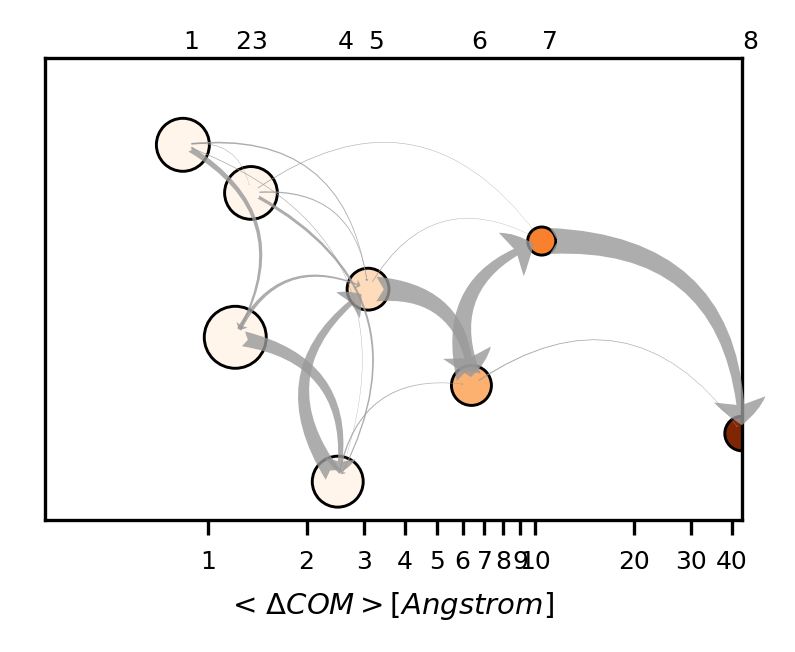

In [17]:
Flow_total = []
for ligand in df_clust['ligand'].unique(): #name_mu:
    print("================ ",ligand," ==========================")
    arg_Label_list,flow = plot_graph_COM(df_clust,dirr_mu+ligand+"byresfirst+200_8CLU.pdf",[ligand],draw_round = False, water=False,edges_show=False,diss_show=False)
    sorted_labels = labels_list[arg_Label_list]
    Flow_total.append((1000.0*flow.flatten()).astype(int))

### 2.2 PP-IFP heatmap of the dissociation trajectories

#### The heatmap shows the content of PP-REs for each cluster along the dissociation

- Clusters are labeled from 1 to 8 (rows) and correspond to the same cluster numbering as above. 

- PP_REs characterizing each cluster are shown on the x-axis (the first residue index refers to barnase and the second refers to barstar). 

- The population of each pair of residue contacts (columns) is shown with a color scale from blue (highest) to white (lowest).

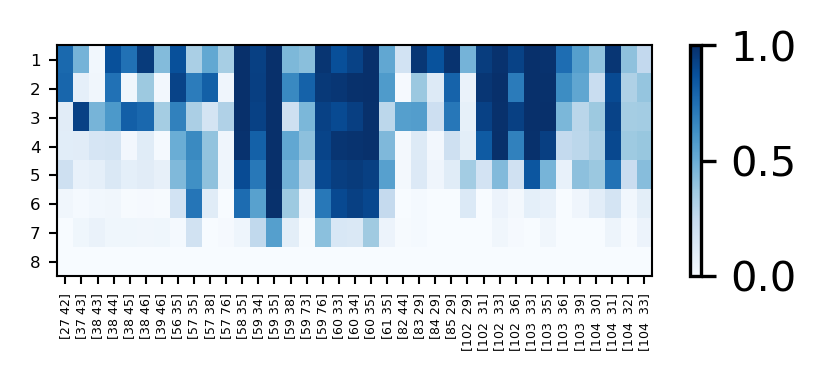

In [18]:
ar = []
com_mean = []
com_std = []
rmsd_mean = []
rmsd_std = []
threshold_cluster_visu =0.1
for l in sorted_labels:
    ar.append(np.mean(df_clust[cols][df_clust.label == l].values,axis=0))
    com_mean.append(np.mean(df_clust["COM"][df_clust.label == l].values,axis=0))
    com_std.append(np.std(df_clust["COM"][df_clust.label == l].values,axis=0))
    rmsd_mean.append(np.mean(df_clust["RMSDl"][df_clust.label == l].values,axis=0))
    rmsd_std.append(np.std(df_clust["RMSDl"][df_clust.label == l].values,axis=0))
ar = np.array(ar)
indx_threshold = np.where(np.mean(ar,axis=0) > threshold_cluster_visu)
ar_reduced = []
for a in ar:
    ar_reduced.append(a[indx_threshold])
    
fig, ax = plt.subplots(figsize = (3.2, 1),dpi=300)
heatmap=ax.imshow(ar_reduced,cmap='Blues',aspect = "auto")
cbar = plt.colorbar(heatmap)
plt.xticks(range(0,indx_threshold[0].shape[0]),np.array(cols)[indx_threshold[0]] ,rotation=90,fontsize=3)
plt.yticks(range(0,len(sorted_labels)),range(1,len(sorted_labels)+1),rotation=0,fontsize=4)
plt.setp(ax.spines.values(), lw=0.5, color='k')
plt.setp(ax.yaxis.get_ticklines(), 'markeredgewidth', 0.5)
plt.setp(ax.xaxis.get_ticklines(), 'markeredgewidth', 0.5)
plt.tick_params('both', length=2, width=0.5, pad=2)
plt.show()


## 3. Clustering of pre-dissociation frames

### 3.1 Extract the part of RAMD trajectories containing the pre-dissociation frames

From step **1.1**:
- convert df_tot into binary as done at step **1.2.1** (**df0**)

- select only PP_REs present in at least one frame (**df1**)

- remove the dissociated frames (**df2**)

- select only frames with less than 3 PP_REs (**df3**) and convert it into a matrix (**X3**)

In [19]:
df0 = (df_tot[cols] < threshold*10) *1 
df1 =df0[df0[cols].sum(axis = 1) > 0]

df2 = df1[df1.columns[df1.sum(0) > 0]]
cols_df2=[]
[cols_df2.append(c) for c in df2.columns.values if str(c[0]).isdigit()]

df3=df2[df2[cols_df2].sum(axis = 1) < 3]
cols_df3=[]
[cols_df3.append(c) for c in df3.columns.values if str(c[0]).isdigit()]
X3 = df3.values
X3.shape

(94, 154)

### 3.2 Plot the pre-dissociation frames with relative PP_REs content

The frames are given along the y-axis and the contact pairs on the x-axis(the first residue index refers to barnase and the second refers to barstar).

[]

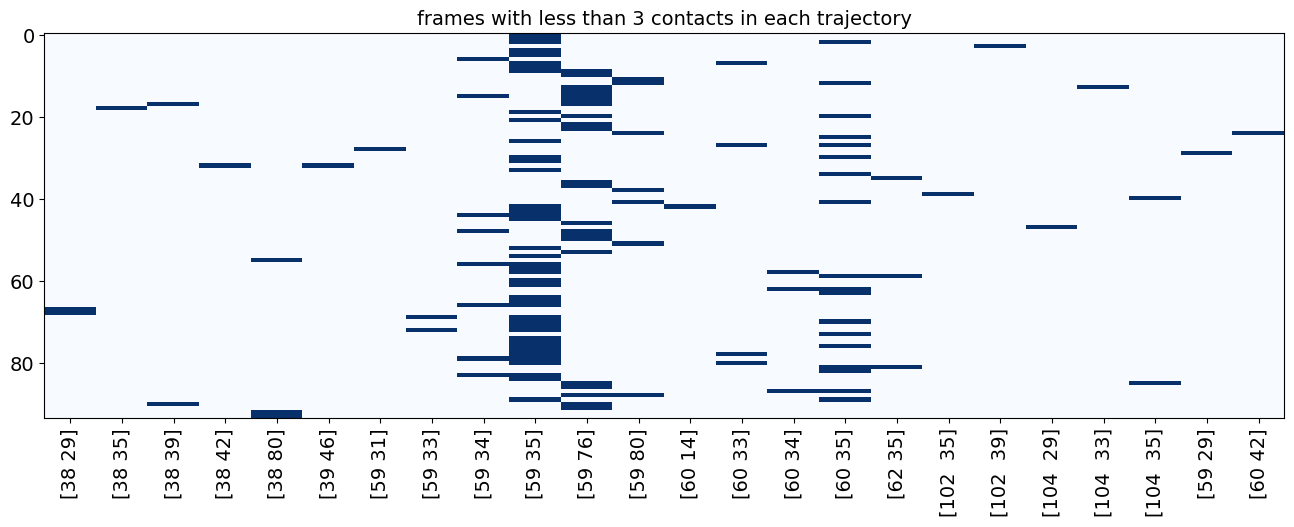

In [20]:
ar_nonzero = X3[:,(np.array(X3).sum(0) > 0)]
columns_IFP_nonzero = np.asarray(cols_df3)[np.argwhere((np.array(X3).sum(0)>0)).flatten()]

fig = plt.figure(figsize = (16,5),facecolor='w')
plt.imshow(ar_nonzero.astype(float),cmap='Blues',aspect = "auto")
plt.xticks(range(0,len(columns_IFP_nonzero)),columns_IFP_nonzero,rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title("frames with less than 3 contacts in each trajectory", fontsize=14)
plt.plot()

### 3.3 Hierarchical clustering of the pre-dissociation frames

- Trajectories having the same IFP content are clustered together.

- Clusters with more than 5 trajectories are shown (1 per row) and ordered on the y-axis from the most populated to the lowest populated. Clusters are labeled by the corresponding number of trajectories. 

- The pairs of residue contacts characterizing the clusters are shown on the x-axis (the first residue index refers to barnase and the second refers to barstar). 

- The occurrence of each pair of residue contacts, computed from MD-IFP analysis, across the trajectories is shown by the corresponding number within each cell and with a color scale from black (highest) to white (lowest).

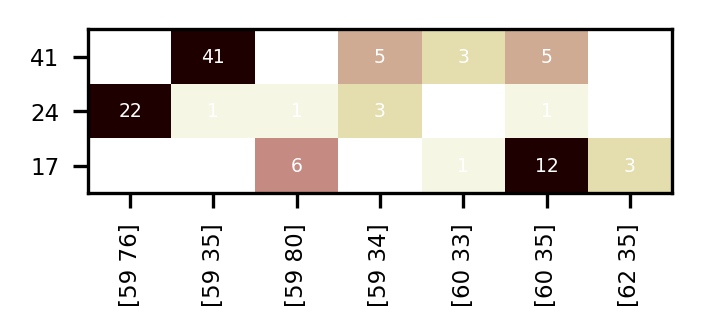

In [21]:
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import *

X4 = ar_nonzero.astype(float)

Z= linkage(X4, method = 'average', metric='correlation', optimal_ordering=True)
threshold =1

clusters = fcluster(Z,threshold, criterion='distance')

cl, count = np.unique(clusters,return_counts=True )
t_cluster = []
t_std_cluster = []
ifps_cluster = []
count_cluster = []
cl_cluster = []

# estimate residence time and population for each cluster 
for k,c in zip(cl,count):
    ind = np.argwhere(clusters==k).flatten() # trajectories in the cluster k
    ifps_mean = np.mean(X[ind,:],axis=0)
    if c > 5:             #minimum number of trajectories per cluster
        cl_cluster.append(k)
        count_cluster.append(c)
        ifps_cluster.append(np.sum(ar_nonzero.astype(float)[ind,:],axis=0))
#     print(cl_cluster, count_cluster, ifps_cluster)  


# order clusters by the number of trajectories 
count_cluster = np.array(count_cluster)
cl_cluster = np.array(cl_cluster)
index_tau = np.argsort(count_cluster)

##select IFP to show 
index = []
for a in columns_IFP_nonzero:
    index.append(int(a[0]))
# print(index)
index = np.argsort(index)
# print(np.asarray(ifps_cluster)[index_tau][:,index])
ifp_subset_large = (np.max(np.asarray(ifps_cluster)[index_tau][:,index],axis=0) > 2)
# print (np.max(np.asarray(ifps_cluster)[index_tau][:,index],axis=0) > 2)
index = index[ifp_subset_large]
aa=(np.asarray(ifps_cluster)[np.flip(index_tau)][:,index]) #array with the occupancy over trajectories


orig_map=plt.cm.get_cmap('pink')
reversed_map = orig_map.reversed()

fig, ax = plt.subplots(figsize = (2.508, 0.709),dpi=300)
ax.imshow(np.asarray(ifps_cluster)[np.flip(index_tau)][:,index],cmap=reversed_map,aspect = "auto",vmin=0, vmax=10)
plt.yticks(range(0,cl_cluster[np.flip(index_tau)].shape[0]),count_cluster[np.flip(index_tau)],fontsize=5.5)
plt.xticks(range(0,len(columns_IFP_nonzero[index])),columns_IFP_nonzero[index],rotation=90,fontsize=5.5)



# Loop over data dimensions and create text annotations.
for i in range(0,cl_cluster[np.flip(index_tau)].shape[0]):
    for j in range(0,len(columns_IFP_nonzero[index])):
        text = ax.text(j, i, int(aa[i, j]),ha="center", va="center", color="w",fontsize=4.5)
        



## 4. Supplementary plots

--- To be executed once for all the mutants ---

### 4.1 RMSD of equilibration trajectories

<Figure size 1920x1440 with 0 Axes>

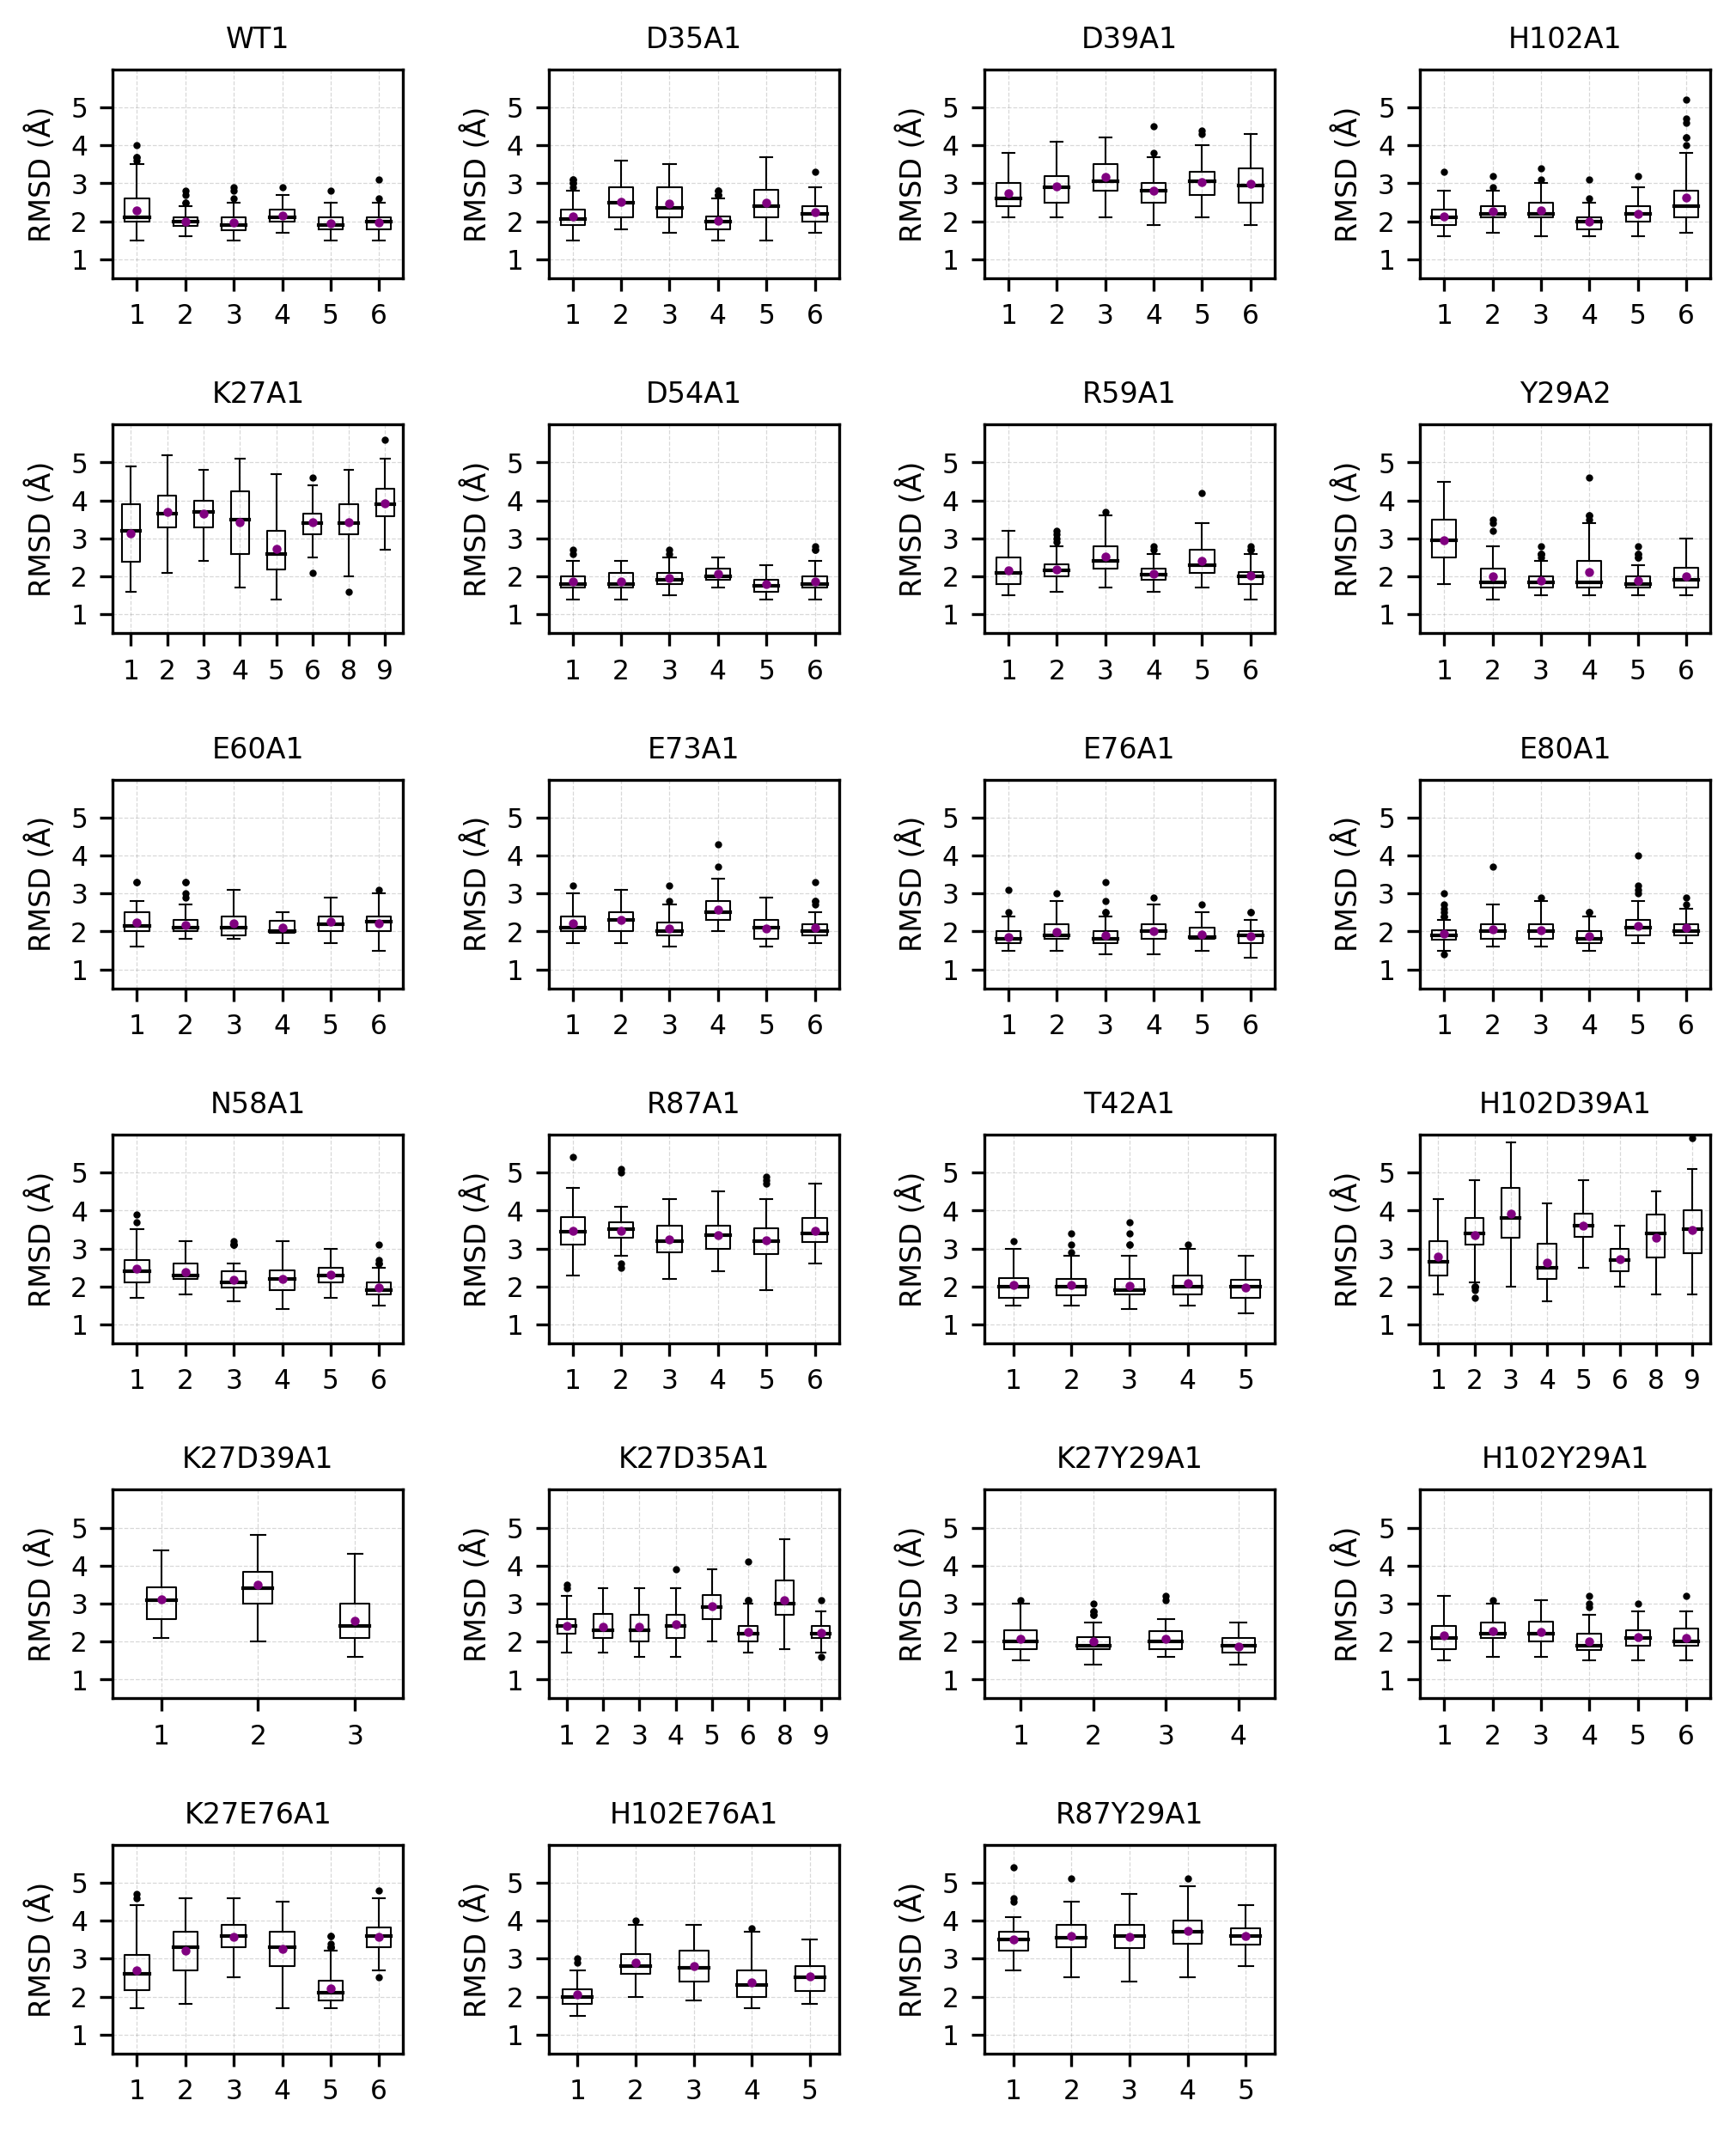

In [15]:
plt.figure(dpi=300)
plot_RMSD_eq(df_E_mu,name_mu)
plt.show()

### 4.2 Interfacial and buried water counting during equilibration trajectories 

- Need to set EQ_WATER to **True**

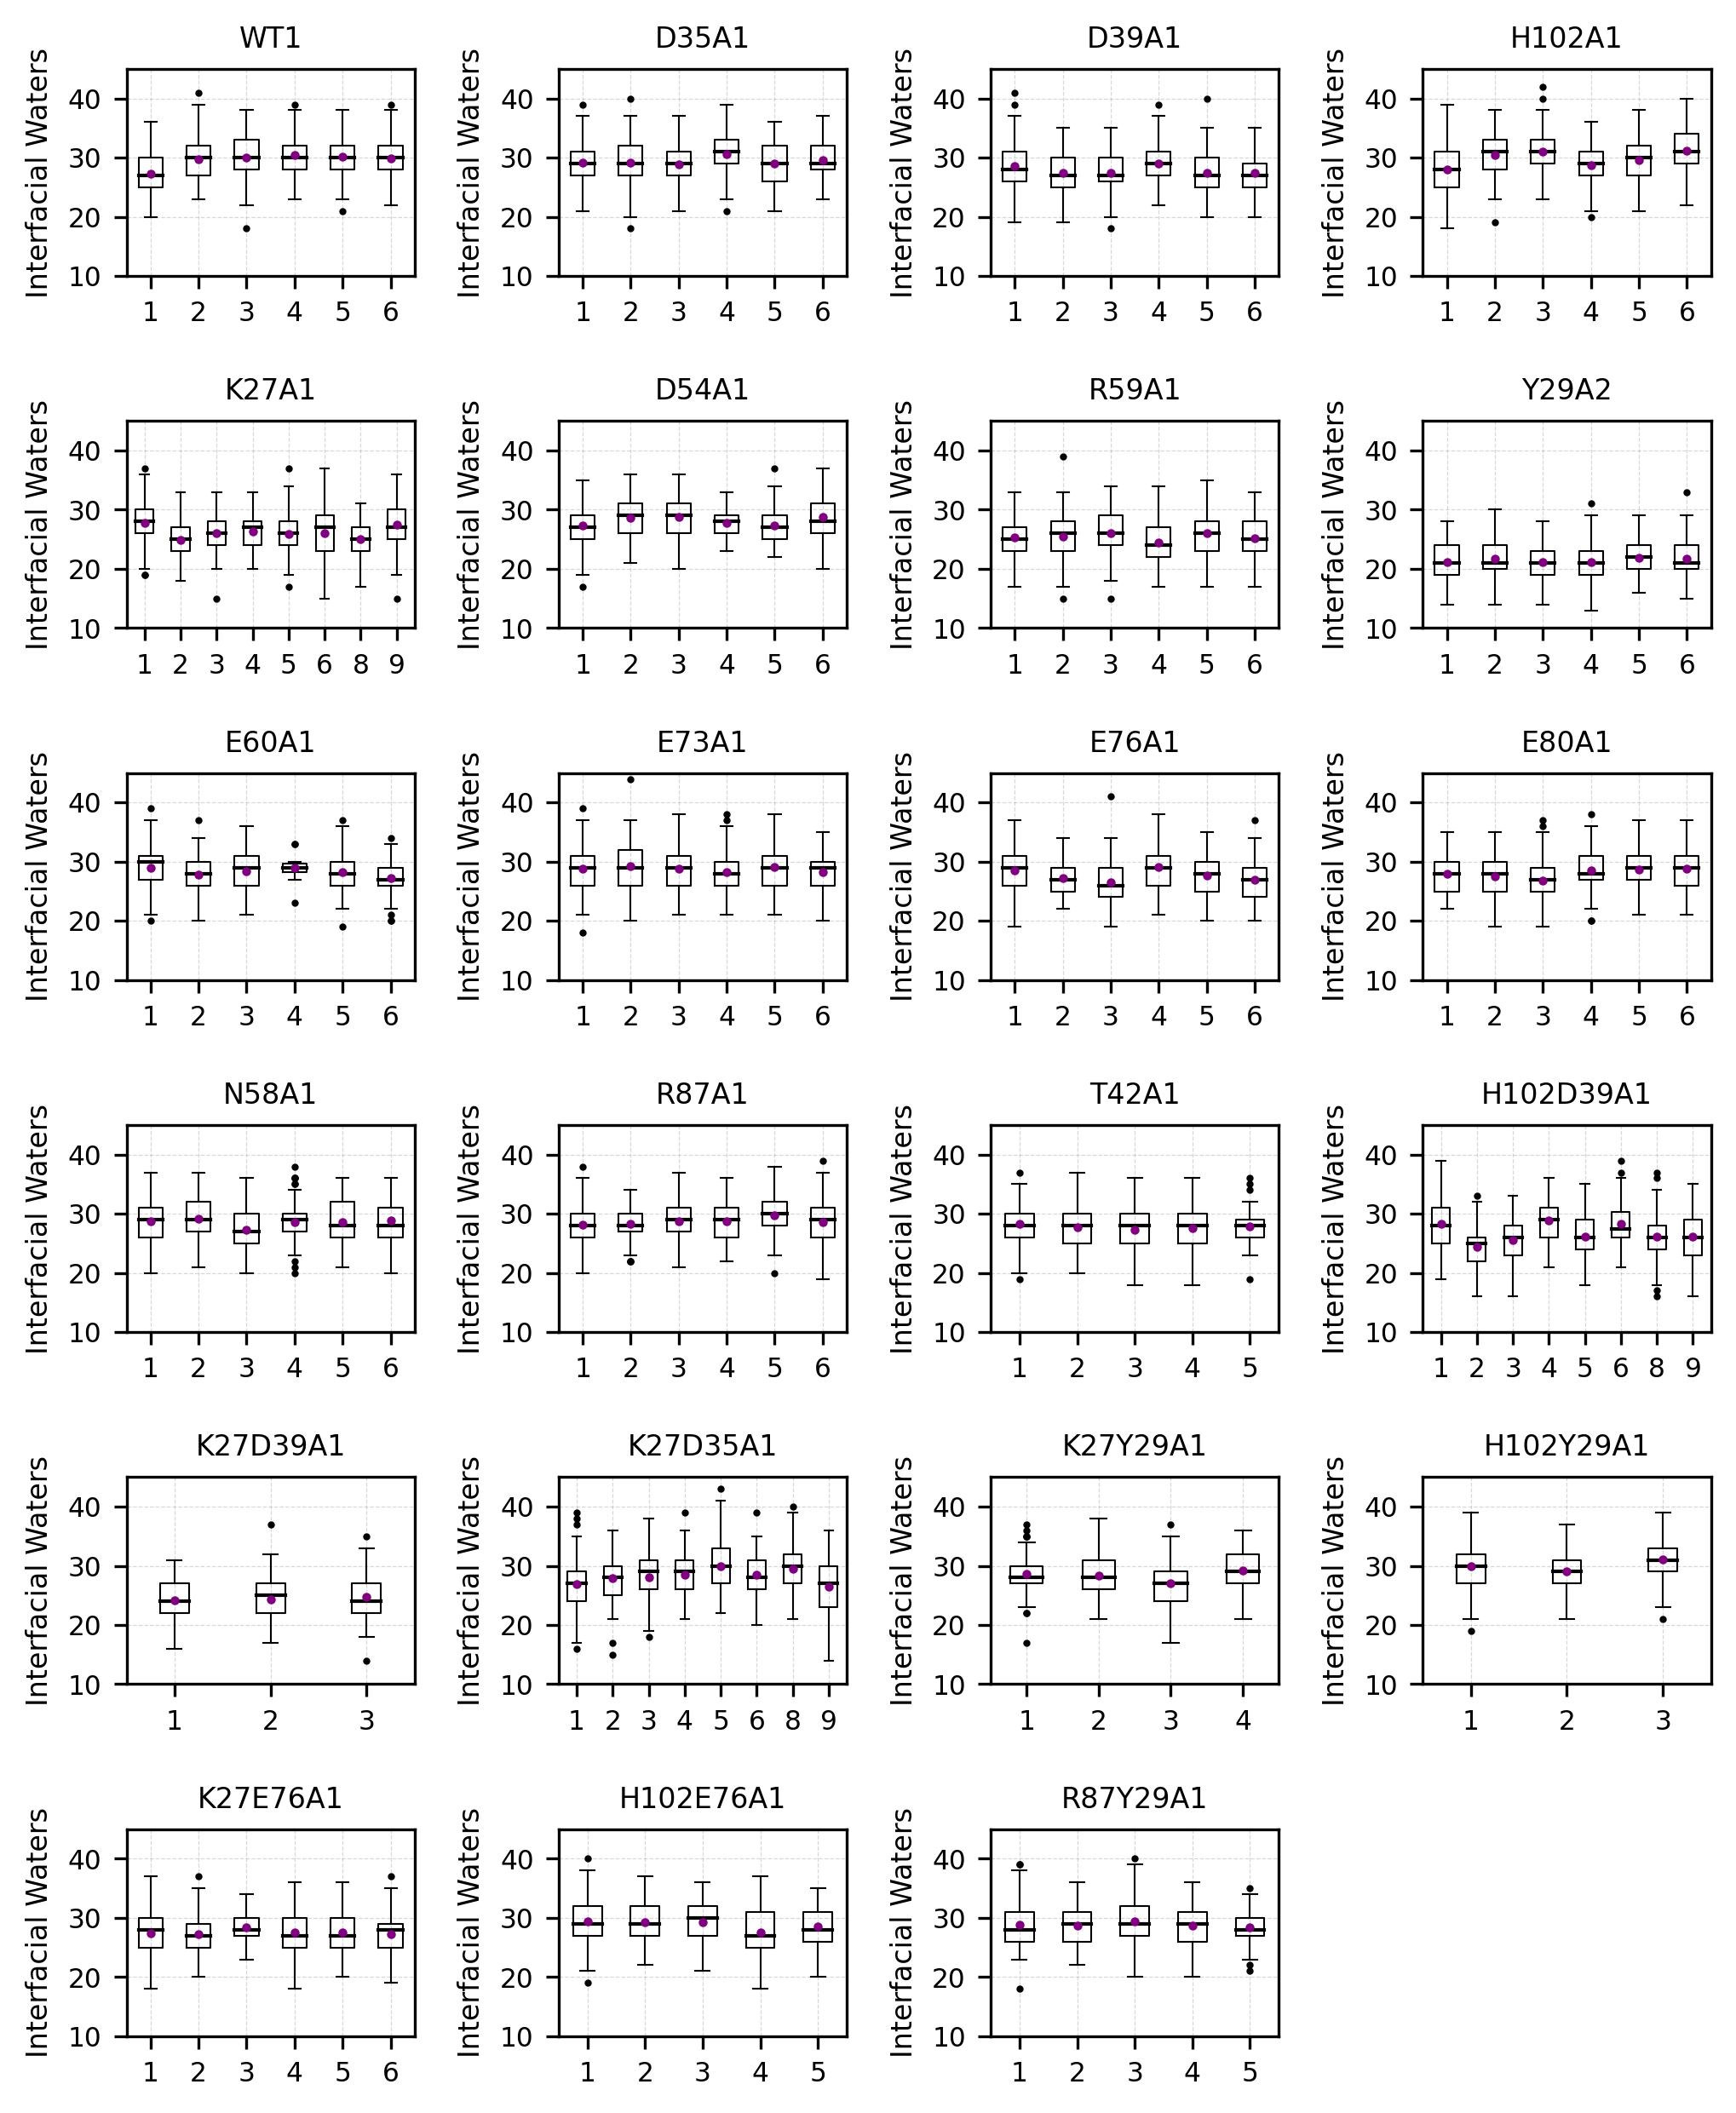

In [16]:
mean_repl_Water_inter(dfW_E_mu,name_mu)


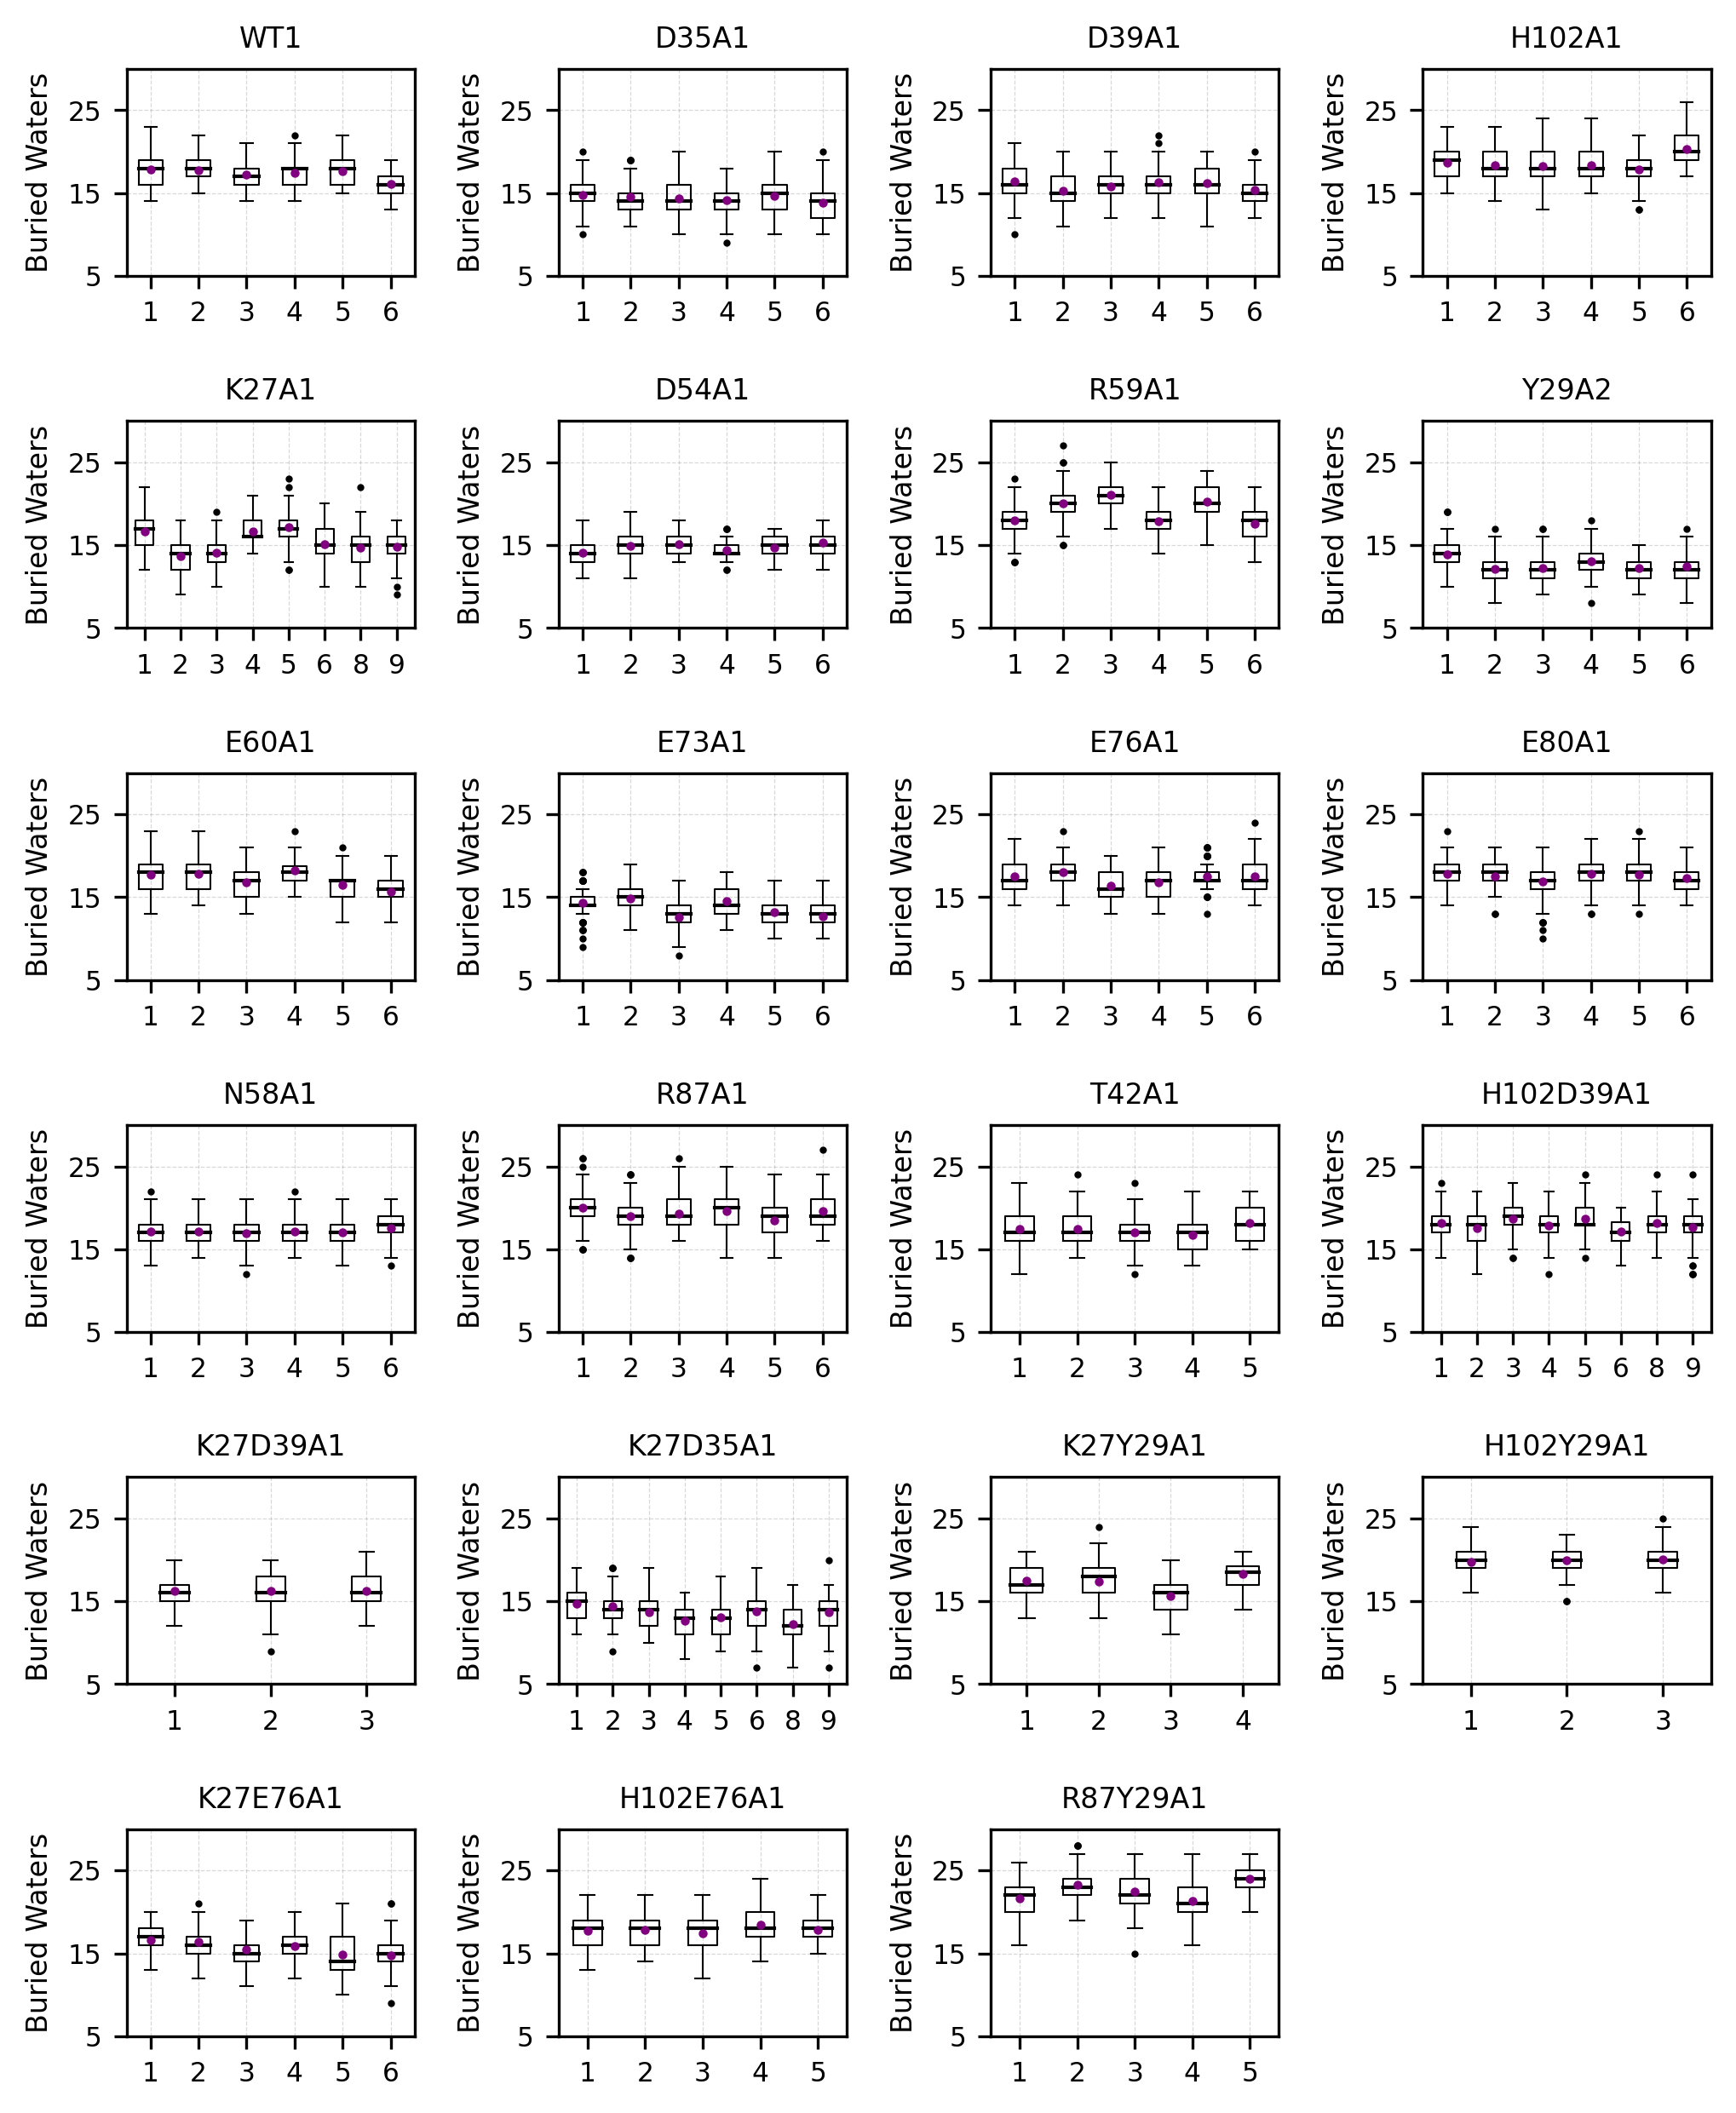

In [14]:
mean_repl_Water_buried(dfW_E_mu,name_mu)
